# «به نام خدا»
## پردازش زبان طبیعی 
## تمرین کامپیوتری شماره 2
## Naive Bayes
### امیرحسین دبیری اقدم - 810197502
#####  دانشگاه تهران - فروردین 1401

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# **Spam or Ham SMS Detection**

In [2]:
df = pd.read_csv('spam.csv',  encoding='ISO-8859-1')

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

{'ham': 0.8659368269921034, 'spam': 0.1340631730078966}

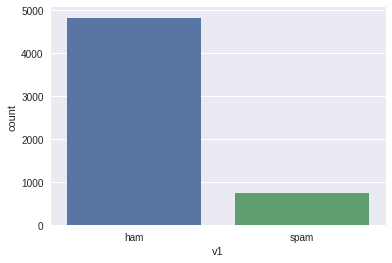

In [5]:
P_ham = sum(df["v1"] == "ham") / len(df["v1"])
Prior = {"ham" : P_ham, "spam" :  1 - P_ham}
sns.countplot(x=df['v1'])
Prior

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    result = []
    for token in text.split(' '):
        if token.lower() not in en_stopwords:
            result.append(token)
    return ' '.join(result)

def stemming(text, stemmer='porter'):
    if (stemmer=='porter'): stemmer = PorterStemmer()
    elif (stemmer=='snowball'): stemmer = SnowballStemmer("english")   
    else: 
        raise ValueError('stemmer should be porter or snowball')
    result = []
    for word in text.split(' '):
        result.append(stemmer.stem(word.lower())) #lower
    return ' '.join(result)

def lemmatizing(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    result = []
    for token in text.split(' '):
        if (not token): continue
        word, tag = pos_tag([token.lower()])[0] #lower
        pos = tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']: pos='n'
        result.append(wordnet_lemmatizer.lemmatize(word, pos)) 
    return ' '.join(result)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
# df['v2'] = df['v2'].apply(lambda X: word_tokenize(X))
# df['v2']=  df['v2'].apply(lambda X: remove_stopwords(X))
df['v2'] = df['v2'].apply(lambda X: stemming(X))
# df['v2'] = df['v2'].apply(lambda X: lemmatizing(X))

In [8]:
df

,v1,v2
0,ham,"go until jurong point, crazy.. avail onli in b..."
1,ham,ok lar... joke wif u oni...
2,spam,free entri in 2 a wkli comp to win fa cup fina...
3,ham,u dun say so earli hor... u c alreadi then say...
4,ham,"nah i don't think he goe to usf, he live aroun..."
...,...,...
5567,spam,thi is the 2nd time we have tri 2 contact u. u...
5568,ham,will ì_ b go to esplanad fr home?
5569,ham,"pity, * wa in mood for that. so...ani other su..."
5570,ham,the guy did some bitch but i act like i'd be i...


In [9]:
X = df['v2']
y = df['v1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=810197502)

In [10]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [11]:
X_train_exclamation = list()
X_train_uppercase = list()
X_train_length = list()
for x in X_train:
    X_train_exclamation.append(x.count('!'))
    X_train_uppercase.append(sum(1 for c in x if c.isupper()))
    X_train_length.append(len(x))   
mean_length = np.mean(X_train_length)
for i in range(len(X_train_length)):
    if(X_train_length[i] > mean_length):
        X_train_length[i] = 1
    else:
        X_train_length[i] = 0

X_test_exclamation = list()
X_test_uppercase = list()
X_test_length = list()
for x in X_test:
    X_test_exclamation.append(x.count('!'))
    X_test_uppercase.append(sum(1 for c in x if c.isupper()))
    X_test_length.append(len(x))
mean_length = np.mean(X_test_length)
for i in range(len(X_test_length)):
    if(X_test_length[i] > mean_length):
        X_test_length[i] = 1
    else:
        X_test_length[i] = 0

In [12]:
vectorizer = CountVectorizer(lowercase=True, strip_accents='ascii', encoding='ISO-8859-1')
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [13]:
count_list = X_train_vector.toarray().sum(axis=0)
word_list = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame(count_list, index=word_list, columns=['Frequency'])
word_freq.sort_values(by='Frequency', ascending=False).head(15)

,Frequency
you,1811
to,1783
the,1085
and,795
it,794
in,727
is,712
my,600
me,597
your,565


In [14]:
X_train_vector = hstack((X_train_vector, np.array([X_train_exclamation, X_train_uppercase, X_train_length]).T))
X_test_vector = hstack((X_test_vector, np.array([X_test_exclamation, X_test_uppercase, X_test_length], dtype=float).T))

In [15]:
accuracy = list()
precision = list()
recall = list()
f1 = list()
for a in range(5):
    clf = MultinomialNB(alpha=a)
    clf.fit(X_train_vector, y_train)
    result = precision_recall_fscore_support(y_test, clf.predict(X_test_vector), average='binary', pos_label='ham')
    accuracy.append(100 * metrics.accuracy_score(y_test, clf.predict(X_test_vector)))
    precision.append(100 * result[0])
    recall.append(100 * result[1])
    f1.append(100 * result[2])

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


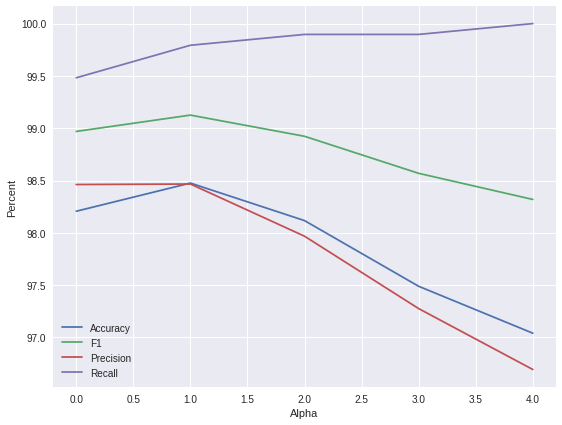

In [16]:
plt.figure(figsize = (9, 7))
plt.plot(np.arange(0, 5, 1), accuracy, label = 'Accuracy')
plt.plot(np.arange(0, 5, 1), f1, label = 'F1')
plt.plot(np.arange(0, 5, 1), precision, label = 'Precision')
plt.plot(np.arange(0, 5, 1), recall, label = 'Recall')
plt.xlabel('Alpha')
plt.ylabel('Percent')
plt.legend()
plt.show()

In [17]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_vector, y_train)
print(classification_report(y_test, clf.predict(X_test_vector), digits=4))

              precision    recall  f1-score   support

         ham     0.9847    0.9979    0.9913       965
        spam     0.9854    0.9000    0.9408       150

    accuracy                         0.9848      1115
   macro avg     0.9850    0.9490    0.9660      1115
weighted avg     0.9848    0.9848    0.9845      1115



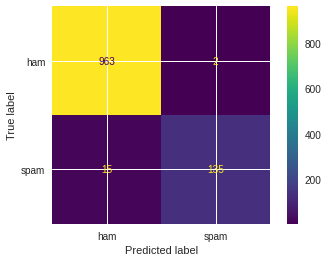

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test_vector), labels=['ham', 'spam'])

In [19]:
i = 1
for x in X_test[(clf.predict(X_test_vector)=='ham') & (y_test=='spam')]:
    print(i, ':', x)
    i += 1

1 : block breaker now come in delux format with new featur and great graphic from t-mobile. buy for just å£5 by repli get bbdelux and take the challeng
2 : hi babe it jordan, how r u? im home from abroad and lonely, text me back if u wanna chat xxsp visionsms.com text stop to stopcost 150p 08712400603
3 : ringtonek 84484
4 : dating:i have had two of these. onli start after i sent a text to talk sport radio last week. ani connect do you think or coincidence?
5 : you'll not rcv ani more msg from the chat svc. for free hardcor servic text go to: 69988 if u get noth u must age verifi with yr network & tri again
6 : more peopl are dog in your area now. call 09090204448 and join like mind guys. whi not arrang 1 yourself. there' 1 thi evening. aå£1.50 minapn ls278bb
7 : hi thi is amy, we will be send you a free phone number in a coupl of days, which will give you an access to all the adult parties...
8 : hi if ur lookin 4 sauci daytim fun wiv busti marri woman am free all next week chat now 2

In [20]:
i = 1
for x in X_test[(clf.predict(X_test_vector)=='spam') & (y_test=='ham')]:
    print(i, ':', x)
    i += 1

1 : u will switch your fone on dammit!!
2 : gettin rdi to ship comp


# **Sentimental LIAR**

In [21]:
# !unzip test_final.zip

In [22]:
df_train = pd.read_csv('train_final.csv')

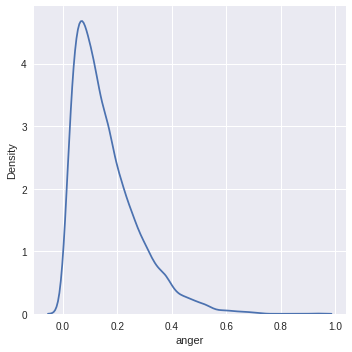

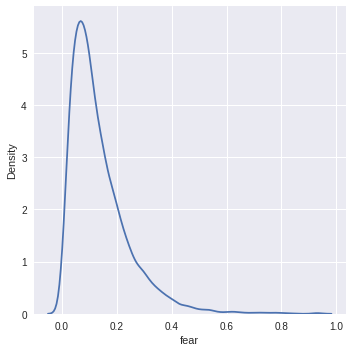

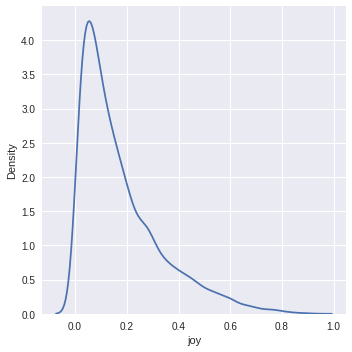

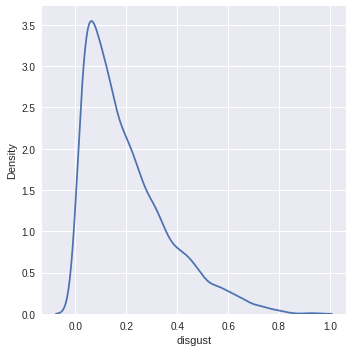

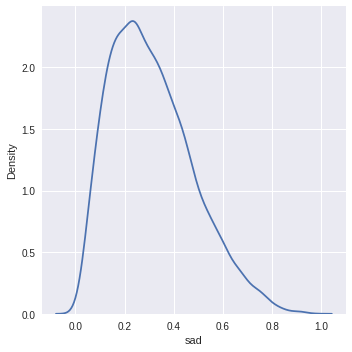

In [23]:
for x in ["anger", "fear", "joy", "disgust", "sad"]:
    sns.displot(df_train, x=x, kind="kde")

In [24]:
def preprocess_df(df, drop_list, threshold=0.375):
    df = df.drop(drop_list, axis=1)
    
    for i in range(len(df)):
        current_label = df.loc[i, 'label']
        if (current_label == 'barely-true' or current_label == 'pants-fire'):
            df.loc[i, 'label'] = 'false'
        elif (current_label == 'mostly-true' or current_label == 'half-true'):
            df.loc[i, 'label'] = 'true'
        
        current_sentiment = df.loc[i, 'sentiment']
        if (current_sentiment == 'POSITIVE'):
            df.loc[i, 'sentiment'] = 1
        else:
            df.loc[i, 'sentiment'] = 0
        
        if(df.loc[i, 'anger'] > threshold):
            df.loc[i, 'anger'] = 1
        else:
            df.loc[i, 'anger'] = 0

        if(df.loc[i, 'fear'] > threshold):
            df.loc[i, 'fear'] = 1
        else:
            df.loc[i, 'fear'] = 0   

        if(df.loc[i, 'joy'] > threshold):
            df.loc[i, 'joy'] = 1
        else:
            df.loc[i, 'joy'] = 0
        
        
        if(df.loc[i, 'disgust'] > threshold):
            df.loc[i, 'disgust'] = 1
        else:
            df.loc[i, 'disgust'] = 0
        
        if(df.loc[i, 'sad'] > threshold):
            df.loc[i, 'sad'] = 1
        else:
            df.loc[i, 'sad'] = 0
    
    return df

In [25]:
drop_list = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
             'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'ID', 'subject', 
             'speaker', 'speaker_job', 'state_info', 'party_affiliation',
             'barely_true_counts', 'false_counts', 'half_true_counts', 
             'mostly_true_counts', 'pants_on_fire_counts', 'context',
             'sentiment_score', 'sentiment_magnitude', 'speaker_id', 'list', 
             'sentiment_code', ]
df_train = preprocess_df(df_train, drop_list,)

In [26]:
# print(len(df_train))
# df_train = df_train.dropna()
# print(len(df_train))

In [27]:
df_train.isna().values.any()

False

In [28]:
# df_train['statement'] = df_train['statement'].apply(lambda X: word_tokenize(X))
# df_train['statement'] = df_train['statement'].apply(lambda X: remove_stopwords(X))
df_train['statement'] = df_train['statement'].apply(lambda X: stemming(X,))
# df_train['statement'] = df_train['statement'].apply(lambda X: lemmatizing(X))

In [29]:
df_train

,label,statement,sentiment,anger,fear,joy,disgust,sad
0,false,say the anni list polit group support third-tr...,0,0.0,0.0,0.0,0.0,1.0
1,true,when did the declin of coal start? it start wh...,0,0.0,0.0,0.0,0.0,0.0
2,true,"hillari clinton agre with john mccain ""bi vote...",0,0.0,0.0,1.0,1.0,0.0
3,false,health care reform legisl is like to mandat fr...,0,0.0,0.0,1.0,0.0,1.0
4,true,the econom turnaround start at the end of my t...,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10231,true,there are a larger number of shark attack in f...,0,0.0,0.0,0.0,0.0,0.0
10232,true,democrat have now becom the parti of the [atla...,0,0.0,0.0,0.0,0.0,1.0
10233,true,say an altern to social secur that oper in gal...,0,0.0,0.0,0.0,0.0,0.0
10234,false,on lift the u.s. cuban embargo and allow trave...,0,0.0,0.0,0.0,0.0,0.0


{'false': 0.4381594372801876, 'true': 0.5618405627198124}

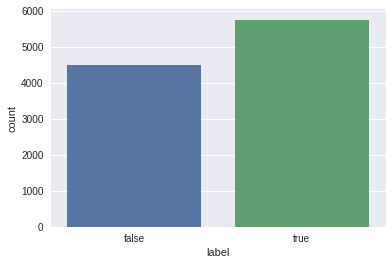

In [30]:
P_true = sum(df_train["label"] == "true") / len(df_train["label"])
Prior = {"true" : P_true, "false" :  1 - P_true}
sns.countplot(x=df_train['label'])
Prior

In [31]:
vectorizer = CountVectorizer(lowercase=True,)
tfidf = TfidfTransformer(sublinear_tf=True)
X_train = df_train['statement']
X_train_vector = vectorizer.fit_transform(X_train)
y_train = df_train['label']

In [32]:
count_list = X_train_vector.toarray().sum(axis=0)
word_list = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame(count_list, index=word_list, columns=['Frequency'])
word_freq.sort_values(by='Frequency', ascending=False).head(15)

,Frequency
the,9777
in,5146
of,4827
to,4501
and,2851
say,2488
for,2126
that,1963
is,1787
on,1523


In [33]:
X_train_vector = hstack((X_train_vector, np.array([df_train['sentiment']], dtype=float).T))

In [34]:
X_train_vector = hstack((X_train_vector, np.array([df_train['anger'], df_train['fear'], df_train['joy'], df_train['disgust'], df_train['sad']], dtype=float).T))

In [35]:
df_test = pd.read_csv('test_final.csv')
drop_list = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
             'Unnamed: 0.1.1.1.1', 'ID', 'subject', 'speaker', 'speaker_job', 
             'state_info', 'party_affiliation', 'barely_true_counts', 
             'false_counts', 'half_true_counts', 'mostly_true_counts', 
             'pants_on_fire_counts', 'context','sentiment_score', 
             'sentiment_magnitude', 'speaker_id', 'list', 'sentiment_code', ]
df_test = preprocess_df(df_test, drop_list,)

In [36]:
# print(len(df_test))
# df_test = df_test.dropna()
# print(len(df_test))

In [37]:
df_test.isna().values.any()

False

In [38]:
# df_test['statement'] = df_test['statement'].apply(lambda X: word_tokenize(X))
# df_test['statement'] = df_test['statement'].apply(lambda X: remove_stopwords(X))
df_test['statement'] = df_test['statement'].apply(lambda X: stemming(X,))
# df_test['statement'] = df_test['statement'].apply(lambda X: lemmatizing(X))

In [39]:
df_test

,label,statement,sentiment,anger,fear,joy,disgust,sad
0,true,build a wall on the u.s.-mexico border will ta...,0,0.0,0.0,0.0,0.0,0.0
1,false,wisconsin is on pace to doubl the number of la...,0,0.0,0.0,0.0,0.0,0.0
2,false,say john mccain ha done noth to help the vets.,0,0.0,0.0,0.0,1.0,1.0
3,true,suzann bonamici support a plan that will cut c...,0,0.0,0.0,0.0,0.0,0.0
4,false,when ask by a report whether he at the center ...,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1262,true,say hi budget provid the highest state fund le...,1,0.0,0.0,0.0,0.0,0.0
1263,false,ive been here almost everi day.,1,0.0,0.0,0.0,0.0,1.0
1264,false,"in the earli 1980s, sen. edward kennedi secret...",1,0.0,0.0,0.0,0.0,0.0
1265,false,say an epa permit languish under strickland bu...,0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_test = df_test['statement']
X_test_vector = vectorizer.transform(X_test)
# X_test_vector = tfidf.transform(X_test_vector)
y_test = df_test['label']

In [41]:
X_test_vector = hstack((X_test_vector, np.array([df_test['sentiment'], ], dtype=float).T))

In [42]:
X_test_vector = hstack((X_test_vector, np.array([df_test['anger'] ,df_test['fear'], df_test['joy'], df_test['disgust'], df_test['sad']], dtype=float).T))

In [43]:
accuracy = list()
precision = list()
recall = list()
f1 = list()
for a in range(5):
    clf = MultinomialNB(alpha=a)
    clf.fit(X_train_vector, y_train)
    result = precision_recall_fscore_support(y_test, clf.predict(X_test_vector), average='binary', pos_label='false')
    accuracy.append(100 * metrics.accuracy_score(y_test, clf.predict(X_test_vector)))
    precision.append(100 * result[0])
    recall.append(100 * result[1])
    f1.append(100 * result[2])

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


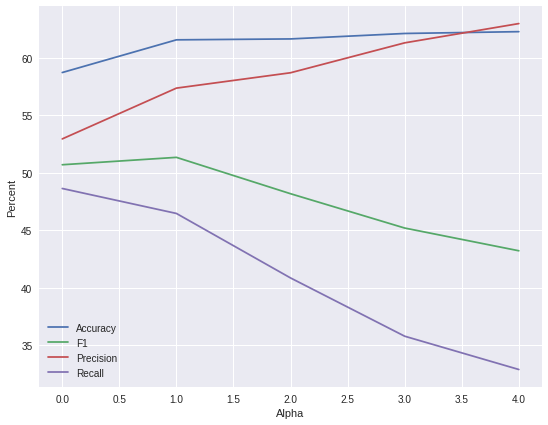

In [44]:
plt.figure(figsize = (9, 7))
plt.plot(np.arange(0, 5, 1), accuracy, label = 'Accuracy')
plt.plot(np.arange(0, 5, 1), f1, label = 'F1')
plt.plot(np.arange(0, 5, 1), precision, label = 'Precision')
plt.plot(np.arange(0, 5, 1), recall, label = 'Recall')
plt.xlabel('Alpha')
plt.ylabel('Percent')
plt.legend()
plt.show()

In [45]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_vector, y_train)
print(classification_report(y_test, clf.predict(X_test_vector), digits=4))

              precision    recall  f1-score   support

       false     0.5737    0.4647    0.5135       553
        true     0.6386    0.7325    0.6823       714

    accuracy                         0.6156      1267
   macro avg     0.6061    0.5986    0.5979      1267
weighted avg     0.6102    0.6156    0.6086      1267



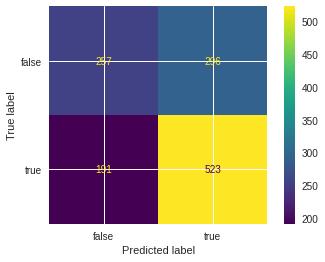

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test_vector))

In [47]:
i = 1
for x in X_test[(clf.predict(X_test_vector)=='true') & (y_test=='false')]:
    print(i, ':', x)
    i += 1

1 : wisconsin is on pace to doubl the number of layoff thi year.
2 : we know there are more democrat in georgia than republicans. we know that for a fact.
3 : say 57 percent of feder spend goe to the militari and just 1 percent goe to food and agriculture, includ food stamps.
4 : unfortun we have document instanc where peopl defec in the (statehouse) building.
5 : ronald reagan face an even wors recess than the current one.
6 : the number of illeg immigr could be 3 million. it could be 30 million.
7 : i wa gone when there wa a red line against syria.
8 : it been sinc 1888 that a senat of a differ parti than the presid in the white hous confirm a suprem court nominee.
9 : under rosemari lehmberg, the travi counti d.a. offic conven the grand juri that indict rick perry.
10 : say bag litter increas after san francisco ban single-us shop bags.
11 : say as a result of the nation health care reform, the congression budget offic say we save $250 million over the first 10 years. over the next 

In [48]:
i = 1
for x in X_test[(clf.predict(X_test_vector)=='false') & (y_test=='true')]:
    print(i, ':', x)
    i += 1

1 : build a wall on the u.s.-mexico border will take liter years.
2 : suzann bonamici support a plan that will cut choic for medicar advantag seniors.
3 : there have not been ani public safeti issu in citi that allow transgend peopl to use the bathroom of the gender they identifi as.
4 : now, there wa a time when someon like scalia and ginsburg got 95-plu votes.
5 : contend that presid obama liter said (if) hi cap-and-trad propos were to pass, that util rates, hi word now, would, necessarili skyrocket.
6 : tom ganley ha two fs from the better busi bureau and over 160 complaint in just three years.
7 : say thoma jefferson said, you might be abl to fool the peopl for awhile, and they may go astray, but sooner or later the american peopl are go to wake up and they will correct the course.
8 : in massachusetts, scott brown push for a law to forc women consid abort -- forc them -- to look at color photograph of develop fetuses.
9 : the fed creat $1.2 trillion out of nothing, gave it to bank